# MIDS W261 Homework Week 5 

#### W261-4 Group 13
Glenn Dunmire, Filip Krunic, Ron Cordell

## HW 5.0

_What is a data warehouse? What is a Star schema? When is it used?_

A data warehouse is a system used for reporting and data analysis and is part of the OLAP (Online Analytical Processing) Pipeline . The data in a data warehouse is uploaded or transformed from other data sources that are used for data stream processing in the OLTP (Online Transaction Processing) Pipeline.

A Star Schema is the simplest way of arranging database tables for data marts. The schema consists of a fact table surrounded by dimension tables. The fact table consists of the basic identifying information for an entity. It is "surrounded" by relationally linked dimension tables that contain attributes the fact table references.

## HW 5.1

_In the database world What is 3NF? Does machine learning use data in 3NF? If so why? 
In what form does ML consume data?
Why would one use log files that are denormalized?_

3NF, or Third Normal Form, is a means of constructing tables schema such that are only part of the keys for the table and do not contain redundant attributes. That is, all column references that do not depend on a primary key should be removed. A Star Schema is an example of 3NF, for example. 

Machine learning can use data in 3NF, depending on the application. However, it is more likely that ML will use data that is denormalized to access all relevant data. In the problem below (5.2) performing joins the data is denormalized to allow further analysis. 

Normalization is useful for saving storage requirements because the data is not repeated but rather referenced by key. However, the act of denormalizing the data to obtain a full picture of the world is an expensive operation. Denormalization of 3NF data is typically performed using JOINs and Map Reduce can perform this operation. However storage is not as much of a concern so 3NF is not a requirement and only adds complexity and processing overhead.

Denormalized log files are common across many scenarios - from operational and systems logs that can be joined by a time stamp to click streams that can be joined based on an ad id or a user or session id. These activity logs are typically just streams of data and can be used stand-alone of joined to other data. The ability to track users across web sessions is an example of click stream log data that is denormalized but can be joined with user information to create a comprehensive record of web activity.

## HW 5.2
Using MRJob, implement a hashside join (memory-backed map-side) for left, 
right and inner joins. Run your code on the  data used in HW 4.4: (Recall HW 4.4: Find the most frequent visitor of each page using mrjob and the output of 4.2  (i.e., transfromed log file). In this output please include the webpage URL, webpageID and Visitor ID.)
:

Justify which table you chose as the Left table in this hashside join.

Please report the number of rows resulting from:

(1) Left joining Table Left with Table Right

(2) Right joining Table Left with Table Right

(3) Inner joining Table Left with Table Right


__NB__: For convenience, we have taken the example of our code from 4.4 and rewritten it here so we will output the webpageID and Visitor ID and count for the most frequent visitor. In our original version we had included the website URL which will now result from the join. Now this purely has PageID + UserID

In [1]:
%%writefile mostfrequentvisitor.py
#!/usr/bin/python

import csv
from mrjob.job import MRJob
from mrjob.step import MRStep
from collections import Counter
from operator import itemgetter

pageURL = {}


with open('anonymous-msweb.data', 'r') as myfile: #read file
    lines = myfile.readlines()
    for line in lines:
        line = line.strip() 
        line = line.split(',') #comma separated
        if line[0] == 'A': #gets url from anonymous file
            pageURL[str(line[1])] = line[4].rstrip() #get URL
        

#quick function to read a csv file properly
def csv_readline(line):
    for row in csv.reader([line]):
        return row

class MRMostFreqVis(MRJob):
    
    #structure is V, page ID, 1, C, customer ID
    def mapper(self, _, line):
        row = csv_readline(line)
        page = row[1]
        vis = row[4]
        yield page, vis
    
    def reducer(self, page, vis):
        visitors = Counter() #note use of counter
        for visitor in vis:
            visitors[visitor] += 1
        topVis = max(visitors.iteritems(), key = itemgetter(1))[0] #get top visitor to each page
        yield int(page), int(topVis)
        
        
if __name__ == '__main__':
    MRMostFreqVis.run()

Overwriting mostfrequentvisitor.py


In [2]:
!python mostfrequentvisitor.py msweblog.csv > mostFrequent.txt

no configs found; falling back on auto-configuration
no configs found; falling back on auto-configuration
creating tmp directory /var/folders/tx/cr7tg62d7rdd750f_czjczfm0000gn/T/mostfrequentvisitor.dunmireg.20160219.000551.732928

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to /var/folders/tx/cr7tg62d7rdd750f_czjczfm0000gn/T/mostfrequentvisitor.dunmireg.20160219.000551.732928/step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to /var/folders/tx/cr7tg62d7rdd750f_czjczfm0000gn/T/mostfrequentvisitor.dunmireg.20160219.000551.732928/step-0-mapper-sorted
> sort /var/folders/tx/cr7tg62d7rdd750f_czjczfm0000gn/T/mostfrequentvisitor.dunmireg.20160219.000551.732928/step-0-mapper_part-00000
writing to /var/folders/tx/cr7tg62d7rdd750f_czjczfm0000gn/T/mostfrequentvisit

In [3]:
#write URL and PageID to separate file
with open('anonymous-msweb.data', 'r') as inputFile, open('url_IDs.txt', 'wb') as outputFile: #set up files
    lines = inputFile.readlines()
    for line in lines:
        line = line.split(',') #comma separated
        if line[0] == 'A': #tells us which lines contain URLs
            result = line[1] + '\t' + line[4]
            outputFile.write(result)

In these joins we decided to treat the URL file as the left table, meaning the file with the URLs is the left table. Technically this table is slightly larger than the right table of top visitors, and generally the left table is loaded into memory and is the smaller table. However, we believe that structurally it is more likely a url table will be smaller than total visitor logs. Perhaps this is not the case, but we thought this was reasonable. Eespecially because the tables were only different by 1 KB. This means the Inner and Right joins will be almost the same, and will output 285 rows, because all visitors visited at least one page. The Left join will visit slightly more pages at 294 because there are several pages that were never visited. 

__Inner Join__

In [4]:
%%writefile innerJoin.py
#!/usr/bin/python
from mrjob.job import MRJob

class InnerJoinJob(MRJob):
    
    #to run before the mapper, build a dictionary of Ids
    def mapper_init(self):
        self.webIDs = {} #holds IDs
        with open('url_IDs.txt', 'r') as myfile: #open url file passed as argument
            lines = myfile.readlines()
            for line in lines:
                line = line.strip()
                line = line.split('\t') #tab separated
                self.webIDs[line[0]] = line[1] #add url to file
    
    def mapper(self, _, line):
        line = line.split()
        if line[0] in self.webIDs.keys():
            yield self.webIDs[line[0]], line[1] #yield if the visitor has visited a web url and show url

    #Notice no reducer is required
if __name__ == '__main__':
    InnerJoinJob.run()

Overwriting innerJoin.py


In [6]:
# from innerJoin import InnerJoinJob
# mr_job = InnerJoinJob(args = ['mostFrequent.txt', '--file', 'url_IDs.txt'])
# rows = 0

# with mr_job.make_runner() as runner:
#     runner.run()
#     for line in runner.stream_output():
#         rows += 1
#         print mr_job.parse_output_line(line)
# print "Number of rows " + str(rows)

('"/regwiz"', '36585')
('"/support"', '23995')
('"/athome"', '35235')
('"/kb"', '22469')
('"/search"', '35540')
('"/norge"', '10004')
('"/misc"', '27495')
('"/ie_intl"', '19492')
('"/msdownload"', '35236')
('"/windows"', '22504')
('"/vbasic"', '20915')
('"/officedev"', '40152')
('"/outlookdev"', '37811')
('"/vbasicsupport"', '32727')
('"/officefreestuff"', '20914')
('"/msexcel"', '16662')
('"/excel"', '35542')
('"/products"', '37091')
('"/isapi"', '34620')
('"/mspowerpoint"', '16765')
('"/msdn"', '39325')
('"/visualc"', '35234')
('"/truetype"', '15906')
('"/spain"', '16079')
('"/iis"', '20447')
('"/gallery"', '35234')
('"/sitebuilder"', '23990')
('"/intdev"', '35234')
('"/oledev"', '11191')
('"/clipgallerylive"', '33083')
('"/ntserver"', '20447')
('"/msoffice"', '22505')
('"/games"', '35542')
('"/logostore"', '38870')
('"/ie"', '35540')
('"/windowssupport"', '22469')
('"/organizations"', '22505')
('"/windows95"', '19490')
('"/sbnmember"', '36585')
('"/isp"', '26948')
('"/office"', '160

__Left Join__

In [7]:
%%writefile leftJoin.py
#!/usr/bin/python
from mrjob.job import MRJob

class LeftJoinJob(MRJob):
    
    #Before mapper run 
    def mapper_init(self):
        self.webIDs = {} #build dictionary for storing urls
        with open('url_IDs.txt', 'r') as myfile:
            lines = myfile.readlines() 
            for line in lines:
                line = line.strip()
                line = line.split('\t') #tab separated
                self.webIDs[line[0]] = line[1] #add ID as key and url as value
    
    def mapper(self, _, line): #read regular input
        line = line.split()
        if line[0] in self.webIDs.keys(): #if a visitor has visited a page, remember these are top visitors
            webID = self.webIDs[line[0]]
            del self.webIDs[line[0]] #remove from dictionary to allow looping
            visitor = line[1]
            yield webID, visitor #yield the url and the visitor
    
    #run after the mapper
    def mapper_final(self):
        for key in self.webIDs.keys(): #for all remaining urls, these are ones no one visited
            url = self.webIDs[key] 
            yield url, 'Not Visited'
        
if __name__ == "__main__":
    LeftJoinJob.run()

Overwriting leftJoin.py


In [8]:
# from leftJoin import LeftJoinJob
# mr_job = LeftJoinJob(args = ['mostFrequent.txt', '--file', 'url_IDs.txt'])
# rows = 0

# with mr_job.make_runner() as runner:
#     runner.run()
#     for line in runner.stream_output():
#         rows += 1
#         print mr_job.parse_output_line(line)
# print "Number of rows " + str(rows)

('"/regwiz"', '36585')
('"/support"', '23995')
('"/athome"', '35235')
('"/kb"', '22469')
('"/search"', '35540')
('"/norge"', '10004')
('"/misc"', '27495')
('"/ie_intl"', '19492')
('"/msdownload"', '35236')
('"/windows"', '22504')
('"/vbasic"', '20915')
('"/officedev"', '40152')
('"/outlookdev"', '37811')
('"/vbasicsupport"', '32727')
('"/officefreestuff"', '20914')
('"/msexcel"', '16662')
('"/excel"', '35542')
('"/products"', '37091')
('"/isapi"', '34620')
('"/mspowerpoint"', '16765')
('"/msdn"', '39325')
('"/visualc"', '35234')
('"/truetype"', '15906')
('"/spain"', '16079')
('"/iis"', '20447')
('"/gallery"', '35234')
('"/sitebuilder"', '23990')
('"/intdev"', '35234')
('"/oledev"', '11191')
('"/clipgallerylive"', '33083')
('"/ntserver"', '20447')
('"/msoffice"', '22505')
('"/games"', '35542')
('"/logostore"', '38870')
('"/ie"', '35540')
('"/windowssupport"', '22469')
('"/organizations"', '22505')
('"/windows95"', '19490')
('"/sbnmember"', '36585')
('"/isp"', '26948')
('"/office"', '160

__Right Join__

In [9]:
%%writefile rightJoin.py
#!/usr/bin/python
from mrjob.job import MRJob

class RightJoinJob(MRJob):
    
    #run before mapper, create a dictionary of urls
    def mapper_init(self):
        self.webIDs = {}
        with open('url_IDs.txt', 'r') as myfile: #read file from input
            lines = myfile.readlines()
            for line in lines:
                line = line.strip()
                line = line.split('\t') #tab delimited
                self.webIDs[line[0]] = line[1] #WebID is key, value is url
    
    def mapper(self, _, line): #run the mapper
        line = line.split()
        if line[0] in self.webIDs.keys(): #the WebID has a top visitor
            webID = self.webIDs[line[0]]
            visitor = line[1]
            yield webID, visitor #match ID and visitor
        else: #this scenario did not occur but we kep it here for extensibility and to demonstrate the join
            yield 'No Website ID', visitor #this would run if there was visitor who had visited a page without an ID
        
if __name__ == "__main__":
    RightJoinJob.run()

Overwriting rightJoin.py


In [10]:
from rightJoin import RightJoinJob
mr_job = RightJoinJob(args = ['mostFrequent.txt', '--file', 'url_IDs.txt'])
rows = 0

with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        rows += 1
        print mr_job.parse_output_line(line)
print "Number of rows " + str(rows)

('"/regwiz"', '36585')
('"/support"', '23995')
('"/athome"', '35235')
('"/kb"', '22469')
('"/search"', '35540')
('"/norge"', '10004')
('"/misc"', '27495')
('"/ie_intl"', '19492')
('"/msdownload"', '35236')
('"/windows"', '22504')
('"/vbasic"', '20915')
('"/officedev"', '40152')
('"/outlookdev"', '37811')
('"/vbasicsupport"', '32727')
('"/officefreestuff"', '20914')
('"/msexcel"', '16662')
('"/excel"', '35542')
('"/products"', '37091')
('"/isapi"', '34620')
('"/mspowerpoint"', '16765')
('"/msdn"', '39325')
('"/visualc"', '35234')
('"/truetype"', '15906')
('"/spain"', '16079')
('"/iis"', '20447')
('"/gallery"', '35234')
('"/sitebuilder"', '23990')
('"/intdev"', '35234')
('"/oledev"', '11191')
('"/clipgallerylive"', '33083')
('"/ntserver"', '20447')
('"/msoffice"', '22505')
('"/games"', '35542')
('"/logostore"', '38870')
('"/ie"', '35540')
('"/windowssupport"', '22469')
('"/organizations"', '22505')
('"/windows95"', '19490')
('"/sbnmember"', '36585')
('"/isp"', '26948')
('"/office"', '160

## HW 5.3  EDA of Google n-grams dataset
A large subset of the Google n-grams dataset

https://aws.amazon.com/datasets/google-books-ngrams/

which we have placed in a bucket/folder on Dropbox on s3:

   https://www.dropbox.com/sh/tmqpc4o0xswhkvz/AACUifrl6wrMrlK6a3X3lZ9Ea?dl=0 

   s3://filtered-5grams/

In particular, this bucket contains (~200) files (10Meg each) in the format:

	(ngram) \t (count) \t (pages_count) \t (books_count)

For HW 5.3-5.5, for the Google n-grams dataset unit test and regression test your code using the 
first 10 lines of the following file:

googlebooks-eng-all-5gram-20090715-0-filtered.txt

Once you are happy with your test results proceed to generating  your results on the Google n-grams dataset. 

Do some EDA on this dataset using mrjob, e.g., 

- Longest 5-gram (number of characters)
- Top 10 most frequent words (please use the count information), i.e., unigrams
- 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.



HW 5.3.1 OPTIONAL Question:
- Plot the log-log plot of the frequency distributuion of unigrams. Does it follow power law distribution?

For more background see:
https://en.wikipedia.org/wiki/Log%E2%80%93log_plot
https://en.wikipedia.org/wiki/Power_law

__Longest 5-gram (number of characters)__

In [ ]:
%%writefile longest5Gram.py
#!/usr/bin/python
from mrjob.job import MRJob

class longest5Gram(MRJob):
    
    def mapper(self, _, line):
        line = line.split('\t') #tab delimited
        gram = line[0]
        chars = len(list(gram))  #get the length of each gram, whitespace is included in count
        yield None, (chars, gram) #this way all grams will get sorted together
    
    def combiner(self, _, counts):
        yield None, max(counts) #returns highest
    
    def reducer(self, _, counts):
        yield max(counts)
        
        #sortedChars = sorted(list(counts), key = lambda x:x[1], reverse = True)[:5]
        #yield sortedChars[0]
        
if __name__ == "__main__":
    longest5Gram.run()

In [ ]:
#Test case
from longest5Gram import longest5Gram
mr_job = longest5Gram(args = ['googlebooks-eng-all-5gram-20090715-0-filtered.txt'])

with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)

(58, 'Interpersonal Communication Interpersonal communication is')

In [ ]:
#To run on AWS use the following command:
# python longest5Gram.py -r emr \
# s3://filtered-5grams \
# --conf-path mrjob.conf \
# --output-dir=s3://dunmireg/longest5Gram \ 
# --no-output \
# --no-strict-protocol

Run in AWS from the command line results in: 

__159	"ROPLEZIMPREDASTRODONBRASLPKLSON YHROACLMPARCHEYXMMIOUDAVESAURUS PIOFPILOCOWERSURUASOGETSESNEGCP TYRAVOPSIFENGOQUAPIALLOBOSKENUO OWINFUYAIOKENECKSASXHYILPOYNUAT"__

As the longest gram with the appropriate character count

__Top 10 most frequent words (please use the count information), i.e., unigrams__

In [ ]:
%%writefile frequent_words.py
from __future__ import division

from mrjob.job import MRJob
from mrjob.step import MRStep
import mrjob.conf

from operator import itemgetter

class frequentWords(MRJob):

	def configure_options(self):
		
		#""" This function defines the arguments to the job. """

		super(frequentWords, self).configure_options()
		
		self.add_passthrough_option(
			'--head-length', 
			type=int, 
			help='Number of entries to emit from top of sort.'
			)


	def load_options(self, args):

		#""" This function initializes arguments defined in 'configure_options'. """

		super(frequentWords, self).load_options(args)

		if self.options.head_length is None: 
			self.option_parser.error('You must specify the --head-length')
		
		else: 
			self.head_length = self.options.head_length


	def mapper_parse(self, _, line):

		#""" This function parses the incoming datafile and emits the word and its count (value, key). """
		
		line = line.rstrip('\n')
		lineArray = line.split('\t')

		gram = lineArray[0]
		count = lineArray[1]
		words = gram.split()

		for word in words: 
			yield word, int(count)


	def reducer_parse(self, word, counts):

		#""" This function sorts the input and sends it out. """

		yield None, (word, sum(counts))


	def reducer_order(self, _, values):
		
		#""" This function orders the output based on the counts and limits it to the head-length. """

		sortedList = []

		for countTuple in values: 
			sortedList.append(countTuple)

			# Sort and remove 
			if len(sortedList) > self.head_length:
				sortedList = sorted(sortedList, key=itemgetter(1), reverse=True)
				sortedList = sortedList[:-1]

		for countTuple in sortedList: 
			yield countTuple[0], countTuple[1]


	def steps(self):

		#""" This function instructs MRJob what functions to execute when run. """

		return [MRStep(mapper=self.mapper_parse, 
						reducer=self.reducer_parse), 

				# Sort 
				MRStep(reducer=self.reducer_order)]
				


if __name__ == '__main__':
	frequentWords.run()

In [13]:
#Test
from frequent_words import frequentWords
mr_job = frequentWords(args = ['googlebooks-eng-all-5gram-20090715-0-filtered.txt'])

with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)

('the', 27691943)

('of', 18590950)

('to', 11601757)

('in', 7470912)

('a', 6926743)

('and', 6150529)

('that', 4077421)

('is', 4074864)

('be', 3720812)

('was', 2492074)

In [ ]:
#To run on AWS use the following command:
# python frequent_words.py -r emr \
# s3://filtered-5grams \
# --conf-path mrjob.conf \
# --output-dir=s3://fkrunic/top10 \ 
# --no-output \
# --no-strict-protocol

Run on AWS with the command line results in: 

"the"	5490815394

"of"	3698583299

"to"	2227866570

"in"	1421312776

"a"	1361123022

"and"	1149577477

"that"	802921147

"is"	758328796

"be"	688707130

"as"	492170314

As the top 10 words with their counts

__20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency__ 

In [ ]:
%%writefile mostDenseWords.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep

class MostDenseWords(MRJob):
    
    def mapper(self, _, line):
        line = line.split('\t') #tab delimited
        words = line[0].split()
        count = int(line[1]) #get count and render as integer
        pageCount = int(line[2]) #count of how many pages gram appears on
        for word in words:
            yield word.lower(), (count, pageCount) #yield count and pagecount
    
    def reducerTotals(self, word, counts):
        wordCount = [] #placeholder for wordcount
        pageCount = [] #placeholder for page count
        for item in counts:
            wordCount.append(item[0]) #parse count object, tuple = (word count, page count)
            pageCount.append(item[1])
        total = sum(wordCount) #get totals
        pageCountTotal = sum(pageCount)
        yield None, (word, float(total)/pageCountTotal) #get all words together as tuples
        
    def reducerTop10(self, _, total_counts):
        #Note use of list here. This will not work in a larger dataset but this was reasonable in this case
        sortedWordCount = sorted(list(total_counts), key = lambda x:x[1], reverse = True)[:10] #sort all words
        for word in sortedWordCount:
            yield word[0], word[1]
    
    def steps(self):
        return [
            MRStep(mapper = self.mapper, reducer = self.reducerTotals),
            MRStep(reducer = self.reducerTop10)
        ]

if __name__ == "__main__":
    MostDenseWords.run()

In [1]:
from mostDenseWords import MostDenseWords
mr_job = MostDenseWords(args = ['googlebooks-eng-all-5gram-20090715-0-filtered.txt'])

with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)

('lak', 3.072289156626506)
('operand', 2.353448275862069)
('bust', 2.3493975903614457)
('houseless', 2.274891774891775)
('gynecological', 2.2481536189069424)
('denatured', 2.1864406779661016)
('expiration', 2.1568513119533526)
('phe', 2.0408163265306123)
('kiowa', 2.0)
('apiece', 1.9607843137254901)


In [2]:
#To run on AWS use the following command:
# python mostDenseWords.py -r emr \
# s3://filtered-5grams \
# --conf-path mrjob.conf \
# --output-dir=s3://dunmireg/mostDense \ 
# --no-output \
# --no-strict-protocol

Run on AWS from command line yields: 

"xxxx"	11.557291666666666

"blah"	8.0741599073001158

"nnn"	7.5333333333333332

"na"	6.2017491314244637

"oooooooooooooooo"	4.921875

"nd"	4.8543057272352703

"llll"	4.5116279069767442

"oooooo"	4.169650013358269

"ooooo"	3.8586371934672128

"lillelu"	3.7624521072796937

As the most dense words with their density (count of words)/(count of words in corpus)

__Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.__

In [ ]:
%%writefile distribution5Grams.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRDistribution5Gram(MRJob):
    
    def mapper(self, _, line):
        line = line.split('\t') #tab delimited data
        gram = line[0] #get the 5 gram
        chars = len(list(gram)) #get length of 5 gram
        yield str(chars), 1 #yield the length of the 5 gram
    
    def reducer(self, chars, counts):
        total = sum(counts) #collect all counts and sum
        yield chars, total

if __name__ == '__main__':
    MRDistribution5Gram.run()

In [3]:
#To run on AWS use the following command:
# python distribution5Grams.py -r emr \
# s3://filtered-5grams \
# --conf-path mrjob.conf \
# --output-dir=s3://dunmireg/Distributions \ 
# --no-output \
# --no-strict-protocol

In [ ]:
#get output from s3 and assemble into local file
!mkdir ./output
!aws s3 cp --recursive s3://dunmireg/Distributions ./output
!cat ./output/part* > distribution.out
!rm -fR ./output

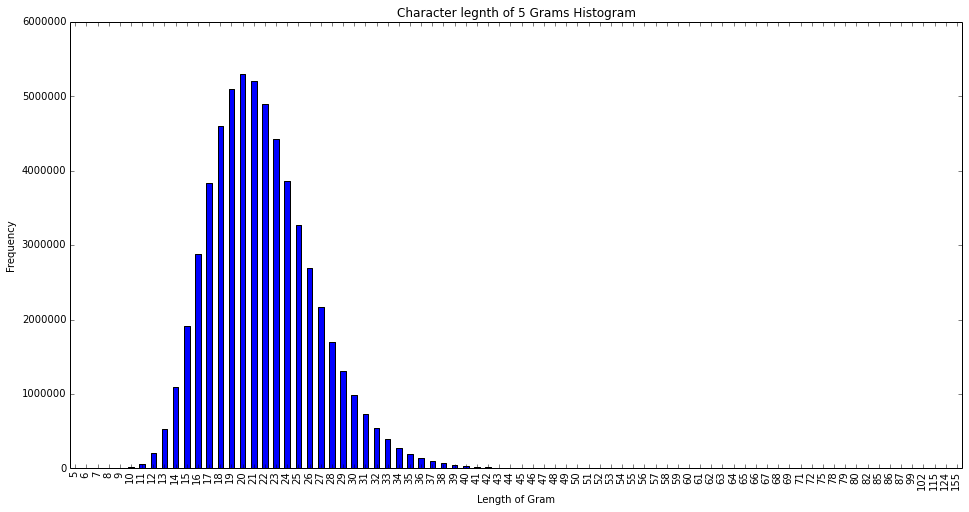

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize'] = 16,8

frame = pd.read_csv('distribution.out', sep = '\t', header = None)
frame.columns = ['gram-length', 'frequency']
frame = frame.sort('gram-length')
frame = frame.set_index('gram-length')
plot = frame.plot(kind = 'bar', legend = None, title = "Character legnth of 5 Grams Histogram")
plot.set_xlabel('Length of Gram')
plot.set_ylabel('Frequency')

### HW 5.4  Synonym detection over 2Gig of Data

For the remainder of this assignment you will work with two datasets:

### 1: unit/systems test data set: SYSTEMS TEST DATASET
Three terms, A,B,C and their corresponding strip-docs of co-occurring terms

DocA {X:20, Y:30, Z:5}
DocB {X:100, Y:20}
DocC {M:5, N:20, Z:5}


### 2: A large subset of the Google n-grams dataset as was described above

For each HW 5.4 -5.5.1 Please unit test and system test your code with respect 
to SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations for the 
SYSTEMS TEST DATASET. Then show the results you get with you system.

In this part of the assignment we will focus on developing methods
for detecting synonyms, using the Google 5-grams dataset. To accomplish
this you must script two main tasks using MRJob:

(1) Build stripes for the most frequent 10,000 words using cooccurence informationa based on
the words ranked from 9001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).


(2) Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.

==Design notes for (1)==
For this task you will be able to modify the pattern we used in HW 3.2
(feel free to use the solution as reference). To total the word counts 
across the 5-grams, output the support from the mappers using the total 
order inversion pattern:

<*word,count>

to ensure that the support arrives before the cooccurrences.

In addition to ensuring the determination of the total word counts,
the mapper must also output co-occurrence counts for the pairs of
words inside of each 5-gram. Treat these words as a basket,
as we have in HW 3, but count all stripes or pairs in both orders,
i.e., count both orderings: (word1,word2), and (word2,word1), to preserve
symmetry in our output for (2).

==Design notes for (2)==
For this task you will have to determine a method of comparison.
Here are a few that you might consider:

- Jaccard
- Cosine similarity
- Spearman correlation
- Euclidean distance
- Taxicab (Manhattan) distance
- Shortest path graph distance (a graph, because our data is symmetric!)
- Pearson correlation
- Kendall correlation
...

However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

Please use the inverted index (discussed in live session #5) based pattern to compute the pairwise (term-by-term) similarity matrix. 

Please report the size of the cluster used and the amount of time it takes to run for the index construction task and for the synonym calculation task. How many pairs need to be processed (HINT: use the posting list length to calculate directly)? Report your  Cluster configuration!





In [ ]:
%%writefile buildTopWords.py
#!/usr/bin/python

#File to build a collection of the words and counts. Modified from 5.3. Sorting will happen locally

from mrjob.job import MRJob
from mrjob.step import MRStep

class BuildTopWords(MRJob):
    
    def mapper(self, _, line): 
        line = line.split('\t') #tab delimited
        words = line[0].split() #get gram
        count = int(line[1]) #get count
        for word in words:
            yield word.lower(), count #yield word and count
    
    def combiner(self, word, counts):
        yield word, sum(counts)
    
    def reducer(self, word, counts): #combine counts
        yield word, sum(counts)

if __name__ == "__main__":
    BuildTopWords.run()

In [ ]:
# from buildTopWords import BuildTopWords
# mr_job = BuildTopWords(args = ['googlebooks-eng-all-5gram-20090715-0-filtered.txt'])

# with mr_job.make_runner() as runner:
#     runner.run()
#     for line in runner.stream_output():
#         result = mr_job.parse_output_line(line)

!python buildTopWords.py googlebooks-eng-all-5gram-20090715-0-filtered.txt -q > words.out

In [ ]:
# !python buildTopWords.py -r emr \
# s3://filtered-5grams \
# --conf-path mrjob.conf \
# --output-dir=s3://dunmireg/topWords \ 
# --no-output \
# --no-strict-protocol

__NB__ Configuration error, results were retrieved from s3 manually

In [ ]:
# !cat part* | sort -k2nr > topwords.txt
!head -10 topwords.txt
!cat topwords.txt | sed -n 9001,10000p > topwords_use.out
!tail -10 topwords_use.out

In [ ]:
%%writefile buildStripes.py
#!/usr/bin/python

from mrjob.job import MRJob
from mrjob.step import MRStep
import urllib2

class BuildStripes(MRJob):
    
    topWords={}

    
    def mapper_init(self): #run before mapper
        top_words = 'https://s3.amazonaws.com/dunmireg/topwords_use.out' #link to file from s3, must be public
        con = urllib2.urlopen(top_words) #open
        data= con.read().strip().split('\n') #split on new line
        top_touse=[] #list to hold results
        for item in data:
            item = item.strip().split('\t') #tab delimited
            top_touse.append(item[0].replace('"','')) #get rid of extra quotes
        self.topWords=set(top_touse) 

    
    def mapper(self, _, line):
        stripe={} #holder for stripe
        line = line.strip().split('\t') #tab delimited
        ngram = line[0] #get ngram
        words = ngram.split() #split into component words
        count = int(line[1]) #get count
        for term in words:
            if term not in self.topWords: #skip if word is not in topwords
                continue
            if term not in stripe: #if word is not already in the strip make a dictionary with it
                stripe[term]={}  
            for word in words: #check all words and increment dictionary accordingly
                if word in self.topWords and term != word:
                    if word not in stripe[term]:
                        stripe[term][word] = count 
                    else:
                        stripe[term][word] += count
        for term, neighbors in stripe.iteritems():
            if len(neighbors) != 0:
                yield term, neighbors
    
    #NB: Filip recommended the use of the combinations package. This would probably be a better idea
       
    def combiner(self,term,neighbors):
        stripe ={} #build stripe
        stripe[term]={}
        for v in neighbors: #loop through list of neighbors
            for key in v:
                if key not in stripe[term]:
                    stripe[term][key] = v[key]
                else :
                    stripe[term][key] += v[key]
        for term, neighbors in stripe.iteritems():
            yield term, neighbors
    
    def reducer(self,term,neighbors): #repeat above process
        stripe ={}
        for v in neighbors:
            for key in v:
                if key not in stripe:
                    stripe[key] = 0
                stripe[key] += v[key]
        yield term, stripe
    
    def steps(self):
        return [
            MRStep(mapper_init=self.mapper_init, mapper=self.mapper, combiner= self.combiner, reducer=self.reducer)
               ]

if __name__ == "__main__":
    BuildStripes.run()

In [ ]:
#!python buildStripes.py googlebooks-eng-all-5gram-20090715-0-filtered.txt -q

In [ ]:
# !python buildStripes.py -r emr \
# s3://filtered-5grams \
# --conf-path mrjob.conf \
# --output-dir=s3://dunmireg/stripesResults \ 
# --no-output \
# --no-strict-protocol

In [ ]:
with open('Systems-Test.txt', 'w') as myfile:
    myfile.write('DocA' + '\t' + '{"X":20,"Y":30,"Z":5}' + '\n')
    myfile.write('DocB' + '\t' + '{"X":100,"Y":20}' + '\n')
    myfile.write('DocC' + '\t' + '{"M":5, "N":20, "Z":5}' + '\n')

__Jaccard Calculation__

Doc A {X:20, Y:30, Z:5}
Doc B {X:100, Y:20}
Doc C {M:5, N:20, Z:5}

-> make inverted index

M {C}

N {C}

X {A, B}

Y {A, B}

Z {A, C}

-> Group values together and sum occurrences

*A, 3

*B, 2

*C, 3

(A,B) 2

(A,C) 1

-> Calculate size

(A,B) = 2/((3+2)-2)

(A,C) = 1/((6+3)-1)

                
-> sum and produce outputs for all pairs
(A, B) = 2/3

(A, C) = 2/8

In [8]:
%%writefile jaccardJob.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep
import csv, re, string

WORD_RE = re.compile(r"[\w']+")

class JaccardJob(MRJob):
    doc_dict = {}
   
    
    def mapper1(self, _, line):
        word,terms = line.strip().split('\t') #tab delimited
        word = word.replace('"', '') #clean word
        syns = eval(terms).keys() #render as dictionary and get keys
        for syn in syns: #yield synonym and original word, making inverted index structure
            yield syn,word
    
    def reducer1(self,key,value):
        doc_list ={} #construct dictionary to hold items
        for v in value: #for each original word associated with a synonym
            doc_list[v]=1 #add to dictionary and binarize
        yield key, doc_list.keys() #yield the key = synonym word and value = list of original words
        
    def mapper2(self,key,value):
        doc_list = list(value) #render original words as as list
        for i in range(0,len(doc_list)): #for all original words
            starkey = '*' + doc_list[i] #use order inversion so this will appear first
            yield (starkey, doc_list[i]),1 #yield current original word
            for j in range(i+1, len(doc_list)): #count all original words that appear with current original word
                yield(doc_list[i],doc_list[j]),1
    
    def combiner2(self,key,value):
        yield key,sum(value) #sum values
    
    def reducer2(self,key,value):
        yield key,sum(value) #sum values
    
    def jcalc(self,key,value):
        docA,docB = key #recall this is a tuple

        if docA.startswith('*'): #The size of how many times each original word appears
            self.global_doc_dict[docB] = sum(value)
        else:  #at this point we have all the |doc|
            ab = sum(value)
            calc = float(ab) / (self.global_doc_dict[docA] + self.global_doc_dict[docB] - ab) #perform calculation
            yield (docA,docB), calc #yield results
 
                   
     def steps(self): #steps for job
        return [
            MRStep(mapper=self.mapper1, reducer= self.reducer1, 
                   jobconf={
                    "mapred.map.tasks":16,
                    "mapred.reduce.tasks":8
                    }),
            MRStep(mapper=self.mapper2 ,combiner=self.combiner2, reducer=self.reducer2,
                   jobconf={
                    "mapred.map.tasks":8,
                    "mapred.reduce.tasks":4
                    }
                  ),
             MRStep(reducer=self.jcalc, 
                    jobconf={
                    "mapred.map.tasks":4,
                    "mapred.reduce.tasks":1
                    })
            
               ]
if __name__ == '__main__':
    JaccardJob.run()

Overwriting jaccardJob.py


In [9]:
%load_ext autoreload
%autoreload 2
from jaccardJob import JaccardJob
mr_job = JaccardJob(args = ['Systems-Test.txt'])

with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)

[autoreload of jaccardJob failed: Traceback (most recent call last):
  File "/Library/Python/2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "jaccardJob.py", line 50
    def steps(self): #steps for job
                                  ^
IndentationError: unindent does not match any outer indentation level
]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(['DocB', 'DocA'], 0.6666666666666666)
(['DocC', 'DocA'], 0.2)


In [ ]:
# !python jaccardJob.py -r emr \
# s3://filtered-5grams \
# --conf-path mrjob.conf \
# --output-dir=s3://dunmireg/jaccardResults \ 
# --no-output \
# --no-strict-protocol

In this configuration we used 4 extra large clusters for a running time of about 320.4 ms. 

Step 1: 
    Map input records: 991
    Map output records: 12138
    Reduce input records: 12138
    Reduce output records: 991
    
Step 2:
    Map input records: 991
    Map output records: 101088
    Reduce input records: 89263
    Reduce output records: 78308

Step 3:
    Map input records: 78308
    Map output records: 78308
    Reduce input records: 78308
    Reduce output records: 77317
    
Processes 77,317 pairs 


#### Cosine Distance Similarity Matrix MRJob Code ####

This MRJob code consists of two passes of mappers and reducers.
The first pass takes each stripe emitted from the striping MRJob and stored in S3 and creates the postings list as a normalized vector.
The second pass takes each of the postings vectors and generates the document pairs and the product of their vector elements.
The final output consists of 

     ["word1","word2"] \t product
     

__Cosine Calculation__

Doc A {X:20, Y:30, Z:5}
Doc B {X:100, Y:20}
Doc C {M:5, N:20, Z:5}

-> get length of each stripe

A {X: 1/sqrt(3), Y: 1/sqrt(3), Z:1/sqrt(3)}

B {X: 1/sqrt(2), Y: 1/sqrt(2)}

C {M: 1/sqrt(3), N: 1/sqrt(3), Z: 1/sqrt(3)}

-> make inverted index

M {C: 1/sqrt(3)}

N {C: 1/sqrt(3)}

X {A: 1/sqrt(3), B: 1/sqrt(2)}

Y {A: 1/sqrt(3), B: 1/sqrt(2)}

Z {A: 1/sqrt(3), C: 1/sqrt(3)}

->  Now look up for each pair of stripes
(Stripe A, Stripe B) = $1/sqrt(3) * 1/sqrt(2) + 1/sqrt(3) * 1/sqrt(2) + 1/sqrt(3) * 0$

                        XeA           XeB        YeA          YeB         ZeA      !ZeB
                
-> sum and produce outputs for all pairs
(A, B) = 2/sqrt(6)

(A, C) = 1/sqrt(9)

In [2]:
%%writefile cosine.py
from mrjob.job import MRJob 
from mrjob.step import MRStep
from mrjob.conf import combine_dicts
from itertools import combinations
from math import sqrt
import re

class MRcosine(MRJob):        
   
    # take apart each stripe, count the coterms and calculate the
    # normal vector length, emit each coterm with it's "document" and length
    def mapper(self, _, line):
        self.increment_counter('Execution Counts', 'mapper', 1)
        term, coterms = line.strip().split('\t')
        # length of the vector
        norm_length = 1.0/sqrt(len(eval(coterms).keys()))
        for coterm in eval(coterms):
            yield re.sub('"','',coterm), {re.sub('"','',term) : norm_length}
            
    # Partition on terms and collect the "documents"
    # yield the inversion of the documents and terms
    def reducer(self, term, docs):
        self.increment_counter('Execution Counts', 'reducer', 1)
        postings = {}
        # iterate throught document dictionaries
        for doc in docs:
            # turn into an actual dictionary and iterate through 
            for item in doc:
                if item in postings:
                    postings[item] += doc[item]
                else:
                    postings[item] = doc[item]
        yield term, postings

    # for each posting yield a pair-wise combination of the documents in the posting list
    # as a tuple key and the product of their weights as the value
    def pairwise_cosine_mapper(self, word, postings):
        postings_list = []
        self.increment_counter('Execution Counts', 'pairwise_cosine_mapper', 1)
        for posting in postings:
             postings_list.append((posting, postings[posting]))
        for doc_pair in combinations(postings_list,2):
            yield (doc_pair[0][0],doc_pair[1][0]),(doc_pair[0][1]*doc_pair[1][1])

    # combiner produces the total pairwise matrix values
    def pairwise_cosine_combiner(self, doc_pair, weights):
        self.increment_counter('Execution Counts', 'pairwise_cosine_combiner', 1)
        yield doc_pair, sum(weights)
            
    # reducer produces the total pairwise matrix values
    def pairwise_cosine_reducer(self, doc_pair, weights):
        self.increment_counter('Execution Counts', 'pairwise_cosine_reducer', 1)
        yield doc_pair, sum(weights)
        
    # define the execution steps
    def steps(self):
        return[MRStep(mapper=self.mapper,
                      reducer=self.reducer
#                      jobconf = {
#                        'mapred.map.tasks' : 20,
#                        'mapred.reduce.tasks' : 20
#                      }
                     ),
               MRStep(mapper=self.pairwise_cosine_mapper,
                      combiner=self.pairwise_cosine_combiner,
                      reducer=self.pairwise_cosine_reducer)
#                      jobconf = {
#                        'mapred.map.tasks' : 20,
#                        'mapred.reduce.tasks' : 20
#                      })
              ]
        
if __name__ == '__main__': 
    MRcosine.run()

Writing cosine.py


In [ ]:
from cosine import MRcosine
mr_job = MRcosine(args = ['Systems-Test.txt'])

with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print mr_job.parse_output_line(line)

(['DocA', 'DocB'], 0.7004041959724748)

(['DocA', 'DocC'], 0.0323761954119088)

(['DocB', 'DocA'], 0.7004041959724748)

(['DocC', 'DocA'], 0.0323761954119088)

#### Cosine Similarity Matrix MRJob Execution ####

The output is included her for interest. Some of the interesting stats:

    AWS EMR Cluster = 1 m3.small, 12 m3.xlarge

    Finished in: 13hrs, 56mins, 37sec
    
    Execution Counts	pairwise_cosine_reducer	746,527,212
                        pairwise_cosine_mapper	52,937
                        
    Map output records	    1,883,898,883
    Combine output records	3,691,846,516
    Reduce output records	746,527,212
    


In [53]:
!aws s3 rm s3://w261-rlc-hw5/mrjob_out --recursive
!python cosine.py -c mrjob.conf \
  --output-dir='s3://w261-rlc-hw5/mrjob_out/' \
  --no-output \
  --strict-protocols \
  -r emr s3://w261-rlc-hw5/mrjob_in/stripes.txt

Got unexpected keyword arguments: ssh_tunnel
inferring aws_region from scratch bucket's region (us-west-1)
using s3://mrjob-ff1bb0ea96bd6412/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/z_/rfp5q2cd6db13d19v6yw0n8w0000gn/T/cosine.rcordell.20160218.161526.146734
writing master bootstrap script to /var/folders/z_/rfp5q2cd6db13d19v6yw0n8w0000gn/T/cosine.rcordell.20160218.161526.146734/b.py
Copying non-input files into s3://mrjob-ff1bb0ea96bd6412/tmp/cosine.rcordell.20160218.161526.146734/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-1K23PBCN27SP7
Created new job flow j-1K23PBCN27SP7
Job launched 30.2s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 60.9s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 91.1s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 121.7s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 152.5s ago, statu

#### AWS S3 Cosine Correlation Matrix Results ####

In [1]:
!aws s3 ls s3://w261-rlc-hw5/mrjob_out/

2016-02-18 22:19:48          0 _SUCCESS
2016-02-18 21:21:27  794255483 part-00000
2016-02-18 21:21:32  794180482 part-00001
2016-02-18 21:21:32  794063645 part-00002
2016-02-18 21:21:34  793976097 part-00003
2016-02-18 21:21:29  794002776 part-00004
2016-02-18 21:21:19  794394053 part-00005
2016-02-18 21:21:31  794109924 part-00006
2016-02-18 21:21:23  793963150 part-00007
2016-02-18 21:21:29  794188494 part-00008
2016-02-18 21:21:27  794063107 part-00009
2016-02-18 21:21:34  794120746 part-00010
2016-02-18 21:21:24  793910782 part-00011
2016-02-18 21:21:39  794161738 part-00012
2016-02-18 21:21:33  794166082 part-00013
2016-02-18 21:21:28  793765259 part-00014
2016-02-18 21:21:31  794073163 part-00015
2016-02-18 21:21:07  794191754 part-00016
2016-02-18 21:21:22  794299704 part-00017
2016-02-18 21:21:33  793927762 part-00018
2016-02-18 21:21:30  794077492 part-00019
2016-02-18 21:21:20  794253091 part-00020
2016-02-18 21:21:11  794216943 part-00021
2016-02-18 21:21:34  794144357 part-

## HW 5.5 Evaluation of synonyms that your discovered
In this part of the assignment you will evaluate the success of you synonym detector (developed in response to HW5.4).
Take the top 1,000 closest/most similar/correlative pairs of words as determined
by your measure in HW5.4, and use the synonyms function in the accompanying
python code:

nltk_synonyms.py

Note: This will require installing the python nltk package:

http://www.nltk.org/install.html

and downloading its data with nltk.download().

For each (word1,word2) pair, check to see if word1 is in the list, 
synonyms(word2), and vice-versa. If one of the two is a synonym of the other, 
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of 
your detector across your 1,000 best guesses. Report the macro averages of these measures.

#### Sort the Similarity Matrix Output for Top !000 ####

Sort the similarity matrix output to obtain the top 1000 scored word pairs.

In [1]:
%%writefile top1Ksimilar.py
from mrjob.job import MRJob 
from mrjob.step import MRStep
from mrjob.conf import combine_dicts
from itertools import combinations
from math import sqrt
import re

class MRtop1Ksimilar(MRJob): 
   
    # read ["word1", "word2"] \t value  line by line
    # emit the true values
    def mapper(self, _, line):
        self.increment_counter('Execution Counts', 'mapper', 1)
        pair, value = line.strip().split('\t')
        yield eval(pair), float(value)
            
    # we'll store the first 1K pairs in a list
    def reducer_init(self):
        self.top1K = []
    
    
    # Expect sorting based on the floating point value, so keep only the first 1K
    def reducer(self, pair, value):
        for v in value:
            if len(self.top1K)<1000:
                self.top1K.append((pair, v))
    
    # Now emit the top 1K pairs and their scores
    def reducer_final(self):
        for (pair, value) in self.top1K:
            yield pair, value
            
        
    # define the execution steps
    def steps(self):
        return[MRStep(mapper=self.mapper,
                      reducer_init=self.reducer_init,
                      reducer=self.reducer,
                      reducer_final=self.reducer_final,
                      jobconf = {
                        'stream.num.map.output.key.fields': 2,
                        'mapreduce.map.output.key.field.separator': '\t',
                        'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                        'mapreduce.partition.keycomparator.options': '-k2,2nr',
                        'mapred.mapper.tasks': 40,
                        'mapreduce.job.reduces': 1
                      }
                     )]
        
if __name__ == '__main__': 
    MRtop1Ksimilar.run()

Writing top1Ksimilar.py


#### Execute the Top 1K MRJob ####

Execute the top 1K job on EMR and take a look at the final output file

In [ ]:
!python top1Ksimilar.py -c mrjob.conf \
  --output-dir='s3://w261-rlc-hw5/mrjob_synonym/' \
  --no-output \
  --strict-protocols \
  -r emr s3://w261-rlc-hw5/mrjob_out/part-00000 \
    s3://w261-rlc-hw5/mrjob_out/part-00001 \
    s3://w261-rlc-hw5/mrjob_out/part-00002 \
    s3://w261-rlc-hw5/mrjob_out/part-00003 \
    s3://w261-rlc-hw5/mrjob_out/part-00004 \
    s3://w261-rlc-hw5/mrjob_out/part-00005 \
    s3://w261-rlc-hw5/mrjob_out/part-00006 \
    s3://w261-rlc-hw5/mrjob_out/part-00007 \
    s3://w261-rlc-hw5/mrjob_out/part-00008 \
    s3://w261-rlc-hw5/mrjob_out/part-00009
        

In [77]:
!aws s3 ls s3://w261-rlc-hw5/mrjob_synonym/

2016-02-18 23:48:56          0 _SUCCESS
2016-02-18 23:48:52      30455 part-00000


In [78]:
!aws s3 cp s3://w261-rlc-hw5/mrjob_synonym/part-00000 .
!head -20 part-00000

download: s3://w261-rlc-hw5/mrjob_synonym/part-00000 to ./part-00000
["symbolize", "orgiastic"]	1.0000000000000002
["contusion", "amputations"]	1.0000000000000002
["couple's", "fan's"]	1.0000000000000002
["livermore", "gregg"]	1.0000000000000002
["italiens", "agricole"]	1.0000000000000002
["intussusception", "catarrh"]	1.0000000000000002
["khurasan", "naivete"]	1.0
["isidorus", "counselors"]	1.0
["kampuchea", "ia"]	1.0
["kalb", "beringia"]	1.0
["jahan", "cleansed"]	1.0
["justifications", "interconnectedness"]	1.0
["kampuchea", "kal"]	1.0
["justifications", "buddhists"]	1.0
["jehan", "psychosis"]	1.0
["judices", "mendicite"]	1.0
["itineracy", "vaisya"]	1.0
["kellerman", "hafiz"]	1.0
["kampuchea", "histoplasmosis"]	1.0
["irrationality", "trieste"]	1.0


__Perform synonym analysis__

In [29]:
from nltk.corpus import wordnet as wn

#helper function to look up synonyms
def findSyns(word):
    holder = {}
    for i,j in enumerate(wn.synsets(word)):
        syns = j.lemma_names()
        for syn in syns:
            holder[syn] = 1
    return holder.keys() #returns synonyms found from the nltk worndet database

with open('cosineResults.out') as myfile:
    syn_data = []
    lines = myfile.readlines()
    for line in lines:
        key, prob = line.strip().split('\t') #tab delimited
        docs = eval(key)
        syn_data.append((docs[0], docs[1], float(prob))) #add word, synonym and probability to list to hold it
    sorted_data = sorted(syn_data, key = lambda row: float(row[2]), reverse = True) #sort list based on probability
    sorted_syn = sorted_data[:1000] #retain only top 1000 per instructions
    
    data_dict = {} #holder for dictionary
    for data in sorted_syn:
        if data[0] not in data_dict.keys(): #initialize a dictionary for words, this will be a word returned by our detector
            data_dict[data[0]] = {'Hit': 0, 'Returned': 0, 'Syns': 0}
        returned_syns = findSyns(data[0]) #get the synonyms from nltk
        if data[1] in returned_syns:
            data_dict[data[0]]['Hit'] += 1 #if a true positive, increment the counter
        data_dict[data[0]]['Returned'] += 1 #this represents a word is returned by our detector
        if data_dict[data[0]]['Syns'] == 0:
            data_dict[data[0]]['Syns'] = len(returned_syns)  #get length of synonyms list
    
    precision = [] #holders for calculating precision and recall
    recall = []
    for key, value in data_dict.iteritems():
        hit = value['Hit'] #unpack values from dictionary
        returned = value['Returned']
        syns = value['Syns']
        if syns == 0: #some words apparently do not have synonyms in this detection, used a 1 here to avoid divide by 0
            syns = 1
        prec = float(hit)/returned #calculate and append precision
        precision.append(prec)
        rec = float(hit)/syns #calculate and append recall
        recall.append(rec)
        
    precisionAvg = sum(precision)/len(precision) #produce averages, probably want numpy
    recallAvg = sum(recall)/len(recall)
    
    print "Cosine precision average: " + str(precisionAvg)
    print "Cosine recall average: " + str(recallAvg)
    print "F1 Score average: " + str((precisionAvg * recallAvg)/(precisionAvg + recallAvg))

Cosine precision average: 0.000825082508251
Cosine recall average: 0.0016501650165
F1 Score average: 0.000550055005501


In [30]:
from nltk.corpus import wordnet as wn

#helper function to look up synonyms
def findSyns(word):
    holder = {}
    for i,j in enumerate(wn.synsets(word)):
        syns = j.lemma_names()
        for syn in syns:
            holder[syn] = 1
    return holder.keys() #returns synonyms found from the nltk worndet database

with open('jaccardOutput.out') as myfile:
    syn_data = []
    lines = myfile.readlines()
    for line in lines:
        key, prob = line.strip().split('\t') #tab delimited
        docs = eval(key)
        syn_data.append((docs[0], docs[1], float(prob))) #add word, synonym and probability to list to hold it
    sorted_data = sorted(syn_data, key = lambda row: float(row[2]), reverse = True) #sort list based on probability
    sorted_syn = sorted_data[:1000] #retain only top 1000 per instructions
    
    data_dict = {} #holder for dictionary
    for data in sorted_syn:
        if data[0] not in data_dict.keys(): #initialize a dictionary for words, this will be a word returned by our detector
            data_dict[data[0]] = {'Hit': 0, 'Returned': 0, 'Syns': 0}
        returned_syns = findSyns(data[0]) #get the synonyms from nltk
        if data[1] in returned_syns:
            data_dict[data[0]]['Hit'] += 1 #if a true positive, increment the counter
        data_dict[data[0]]['Returned'] += 1 #this represents a word is returned by our detector
        if data_dict[data[0]]['Syns'] == 0:
            data_dict[data[0]]['Syns'] = len(returned_syns)  #get length of synonyms list
    
    precision = [] #holders for calculating precision and recall
    recall = []
    for key, value in data_dict.iteritems():
        hit = value['Hit'] #unpack values from dictionary
        returned = value['Returned']
        syns = value['Syns']
        if syns == 0: #some words apparently do not have synonyms in this detection, used a 1 here to avoid divide by 0
            syns = 1
        prec = float(hit)/returned #calculate and append precision
        precision.append(prec)
        rec = float(hit)/syns #calculate and append recall
        recall.append(rec)
        
    precisionAvg = sum(precision)/len(precision) #produce averages, probably want numpy
    recallAvg = sum(recall)/len(recall)
    
    print "Jaccard precision average: " + str(precisionAvg)
    print "Jaccard recall average: " + str(recallAvg)
    print "F1 Score average: " + str((precisionAvg * recallAvg)/(precisionAvg + recallAvg))

Jaccard precision average: 0.00308641975309
Jaccard recall average: 0.000598578376356
F1 Score average: 0.00050134737106


Notice that these both exhibit very low F1 scores. This probably has to do with the sorting and taking the top 1000 as well as the fact we originally drew our sample from the words ranked 9000-1000